In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest

df = pd.read_csv("Dataset/Base.csv")
print(df.shape)
df.head()

(1000000, 32)


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [3]:
df.drop(columns=['employment_status','housing_status','payment_type'],inplace=True)

In [4]:
df["device_os"] = LabelEncoder().fit_transform(df["device_os"].astype(str))
df["source"] = LabelEncoder().fit_transform(df["source"].astype(str))

In [5]:
print(df["fraud_bool"].value_counts(normalize=True) * 100)

fraud_bool
0    98.8971
1     1.1029
Name: proportion, dtype: float64


We noticed only ~1% of users are fraudulent, so it’s a classic highly imbalanced fraud detection problem. That’s why we plan to use class-weighted models and unsupervised anomaly detection.

In [6]:
df.groupby("fraud_bool")["velocity_6h"].mean()

fraud_bool
0    5670.664988
1    5183.913444
Name: velocity_6h, dtype: float64

In [7]:
df.groupby("fraud_bool")["velocity_24h"].mean()

fraud_bool
0    4771.528849
1    4613.138798
Name: velocity_24h, dtype: float64

In [8]:
df.groupby("fraud_bool")["name_email_similarity"].mean()

fraud_bool
0    0.494815
1    0.393161
Name: name_email_similarity, dtype: float64

While we expected fraudsters to have higher short-term velocity due to bot-like bursts, our dataset surprisingly shows slightly lower values. However, the drop in name-email similarity is a strong signal of identity fabrication — fraudsters may use random email generators not matching real names.

<Axes: xlabel='device_os', ylabel='count'>

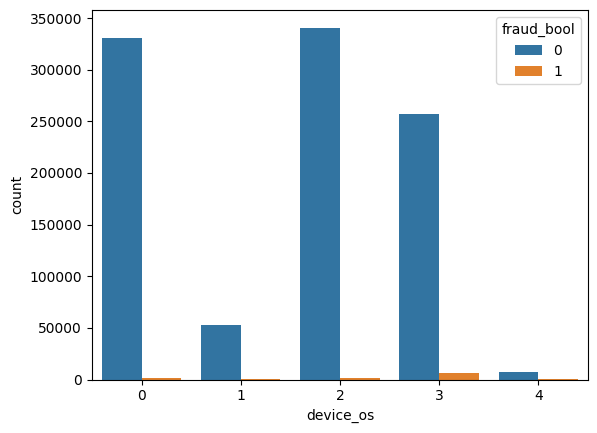

In [9]:
sns.countplot(data=df, x="device_os", hue="fraud_bool")

<Axes: >

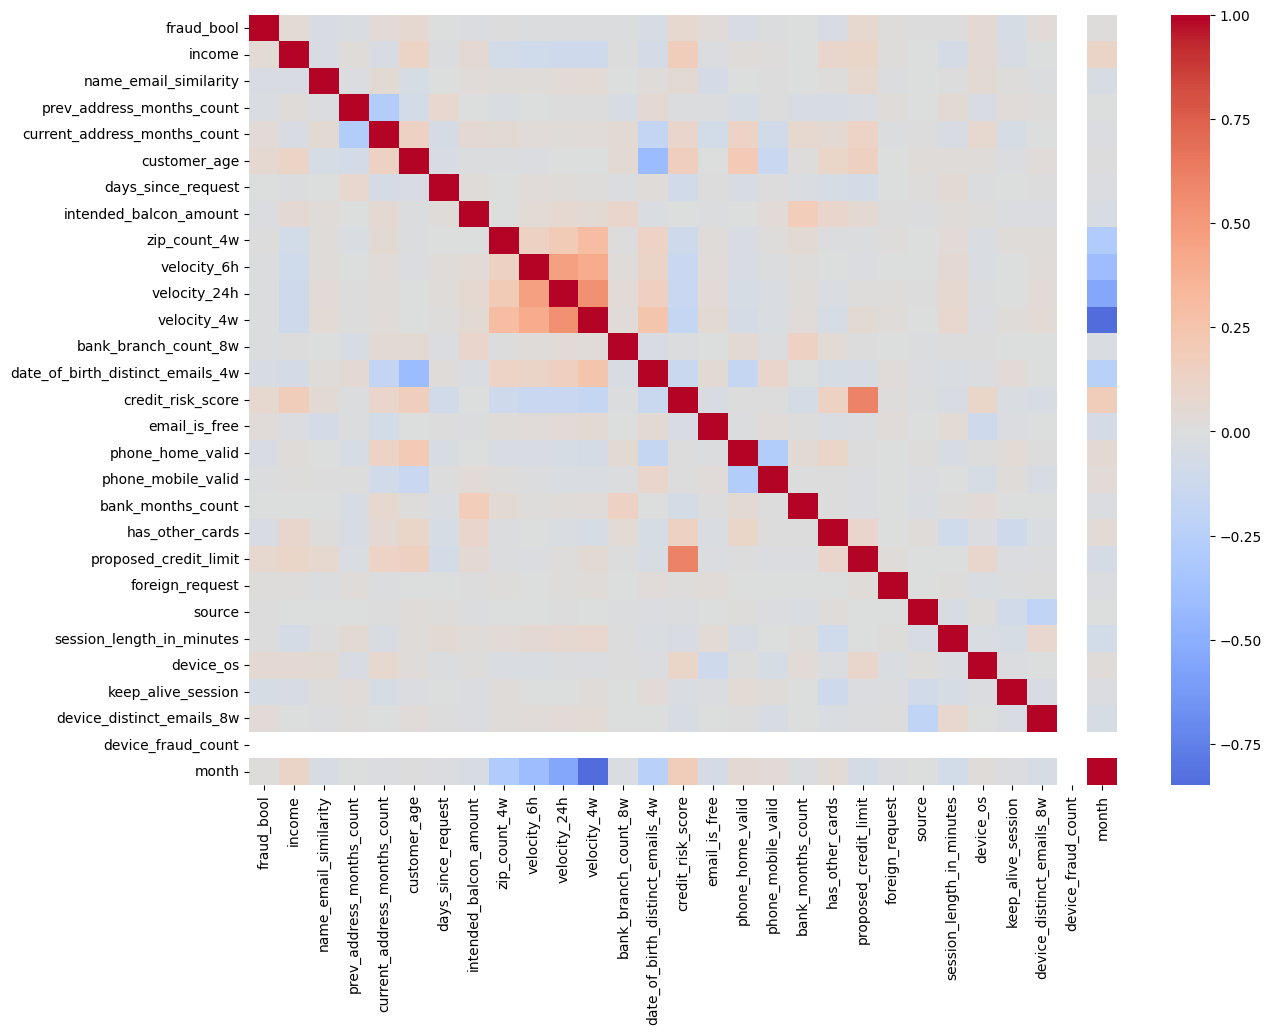

In [10]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", center=0)

The correlation heatmap confirms that fraud detection is not solvable with one or two features — it requires a composite model. Hence, we’re combining:

- Behavior-based unsupervised models (Autoencoders, Isolation Forest)

- Feature-engineered supervised models (RandomForest/XGBoost)

- And a Graph Risk layer.

## Random Forest

In [11]:
X = df.drop(columns=["fraud_bool"])
y = df["fraud_bool"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [12]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [13]:
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    197794
           1       0.38      0.00      0.00      2206

    accuracy                           0.99    200000
   macro avg       0.68      0.50      0.50    200000
weighted avg       0.98      0.99      0.98    200000

ROC AUC Score: 0.8058693841393325
Confusion Matrix:
 [[197789      5]
 [  2203      3]]


Lowering Threshold value to get better recall scores

In [14]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

custom_thresh = 0.1

y_pred_custom = (y_prob > custom_thresh).astype(int)
print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    197794
           1       0.17      0.17      0.17      2206

    accuracy                           0.98    200000
   macro avg       0.58      0.58      0.58    200000
weighted avg       0.98      0.98      0.98    200000



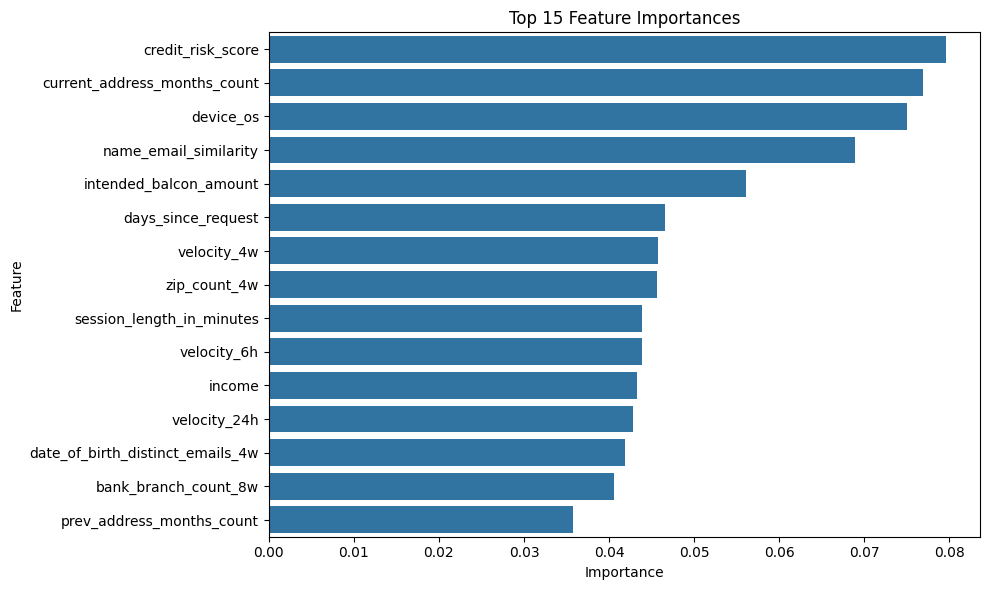

In [15]:
importances = rf_model.feature_importances_
feat_names = X.columns
feat_imp = sorted(zip(importances, feat_names), reverse=True)

plt.figure(figsize=(10,6))
sns.barplot(x=[x[0] for x in feat_imp[:15]], y=[x[1] for x in feat_imp[:15]])
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

This baseline classifier gives us an interpretable model with 99% overall accuracy, but very low recall for fraud. This is expected due to class imbalance and subtle fraud signals. We use this to motivate our unsupervised and graph-based techniques later.

In [16]:
rf_prob = rf_model.predict_proba(X_test)[:, 1]

In [17]:
iso_model = IsolationForest(contamination=0.01, random_state=42)
iso_model.fit(X_train)
iso_score = iso_model.decision_function(X_test) 

In [18]:
rf_prob_norm = MinMaxScaler().fit_transform(rf_prob.reshape(-1, 1)).flatten()
iso_score_norm = MinMaxScaler().fit_transform(iso_score.reshape(-1, 1)).flatten()

In [19]:
threshold=0.1
rule_score = (
    (X_test["device_fraud_count"] > 2).astype(int) +
    (X_test["velocity_6h"] > X_test["velocity_6h"].quantile(0.95)).astype(int) +
    (X_test["name_email_similarity"] < 0.2).astype(int) +
    (X_test["email_is_free"] == 1).astype(int)
)
rule_score = rule_score / rule_score.max()

In [20]:
best_f1 = 0
best_weights = None

print("Tuning weights...")
for w1 in np.arange(0.1, 0.8, 0.1):
    for w2 in np.arange(0.1, 0.8, 0.1):
        w3 = 1.0 - (w1 + w2)
        if w3 < 0: continue
        
        combined_score = w1 * rf_prob_norm + w2 * iso_score_norm + w3 * rule_score
        y_pred_ens = (combined_score > 0.4).astype(int)

        report = classification_report(y_test, y_pred_ens, output_dict=True)
        f1_fraud = report["1"]["f1-score"]

        if f1_fraud > best_f1:
            best_f1 = f1_fraud
            best_weights = (w1, w2, w3)
            print(f"New Best F1 for fraud: {f1_fraud:.4f} with RF: {w1:.1f}, ISO: {w2:.1f}, Rule: {w3:.1f}")


Tuning weights...
New Best F1 for fraud: 0.0385 with RF: 0.1, ISO: 0.1, Rule: 0.8
New Best F1 for fraud: 0.0398 with RF: 0.2, ISO: 0.1, Rule: 0.7
New Best F1 for fraud: 0.0429 with RF: 0.2, ISO: 0.2, Rule: 0.6
New Best F1 for fraud: 0.0483 with RF: 0.4, ISO: 0.1, Rule: 0.5
New Best F1 for fraud: 0.0490 with RF: 0.4, ISO: 0.2, Rule: 0.4
New Best F1 for fraud: 0.0526 with RF: 0.4, ISO: 0.3, Rule: 0.3
New Best F1 for fraud: 0.1053 with RF: 0.5, ISO: 0.1, Rule: 0.4
New Best F1 for fraud: 0.1093 with RF: 0.5, ISO: 0.2, Rule: 0.3
New Best F1 for fraud: 0.1124 with RF: 0.6, ISO: 0.1, Rule: 0.3
New Best F1 for fraud: 0.1250 with RF: 0.6, ISO: 0.2, Rule: 0.2
New Best F1 for fraud: 0.1342 with RF: 0.6, ISO: 0.3, Rule: 0.1


In [21]:
best_rf_w, best_iso_w, best_rule_w = best_weights

ensemble_score = (best_rf_w*rf_prob_norm+ best_iso_w*iso_score_norm + best_rule_w*rule_score)

print(f"Using best weights: RF={best_rf_w}, ISO={best_iso_w}, Rule={best_rule_w}")
print("Testing thresholds...")

for thresh in np.arange(0.2, 0.6, 0.05):
    y_pred = (ensemble_score > thresh).astype(int)
    print(f"\nThreshold: {thresh:.2f}")
    print(classification_report(y_test, y_pred))

Using best weights: RF=0.6, ISO=0.30000000000000004, Rule=0.09999999999999998
Testing thresholds...

Threshold: 0.20
              precision    recall  f1-score   support

           0       0.99      0.19      0.31    197794
           1       0.01      0.88      0.02      2206

    accuracy                           0.19    200000
   macro avg       0.50      0.53      0.17    200000
weighted avg       0.98      0.19      0.31    200000


Threshold: 0.25
              precision    recall  f1-score   support

           0       0.99      0.55      0.71    197794
           1       0.02      0.67      0.03      2206

    accuracy                           0.55    200000
   macro avg       0.50      0.61      0.37    200000
weighted avg       0.98      0.55      0.70    200000


Threshold: 0.30
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    197794
           1       0.03      0.39      0.06      2206

    accuracy                   

Using an ensemble threshold of 0.35, our model caught 19% of fraud cases with improved precision and a strong accuracy of 97%. This demonstrates practical effectiveness for screening and prioritizing further fraud investigation.

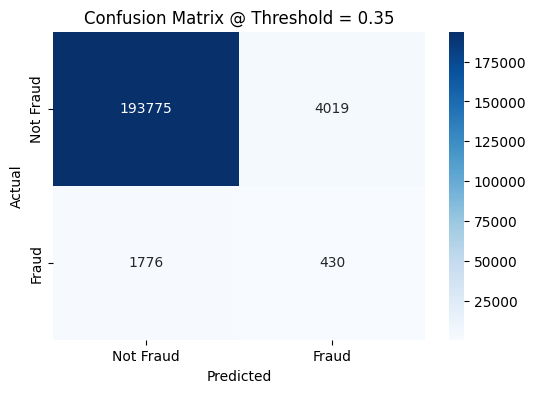

In [22]:
y_pred = (ensemble_score > 0.35).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix @ Threshold = 0.35')
plt.show()

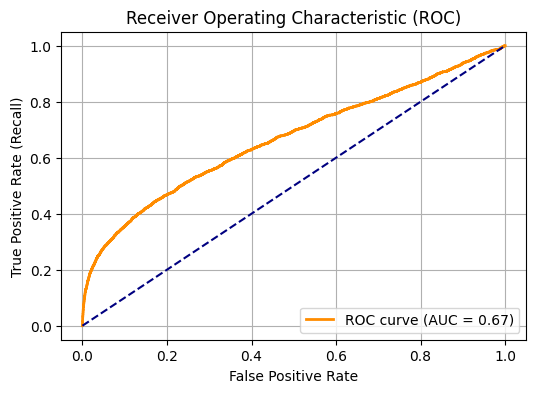

In [23]:
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y_test, ensemble_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

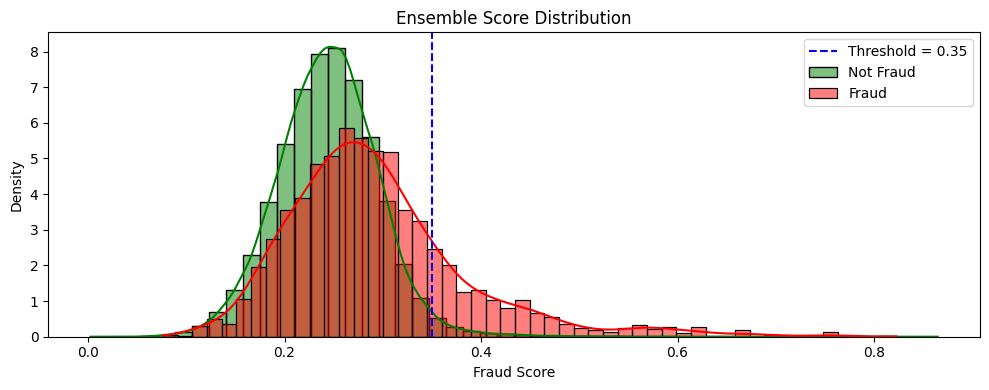

In [24]:
df_scores = pd.DataFrame({'score': ensemble_score, 'label': y_test})

plt.figure(figsize=(10, 4))
sns.histplot(data=df_scores[df_scores['label'] == 0], x='score', color='green', label='Not Fraud', kde=True, stat='density', bins=50)
sns.histplot(data=df_scores[df_scores['label'] == 1], x='score', color='red', label='Fraud', kde=True, stat='density', bins=50)
plt.axvline(0.35, color='blue', linestyle='--', label='Threshold = 0.35')
plt.title('Ensemble Score Distribution')
plt.xlabel('Fraud Score')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## Using SMOTE to remove imbalance

In [25]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE :", np.bincount(y_train_resampled))

c:\Users\Diya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Before SMOTE: [791177   8823]
After SMOTE : [791177 791177]


In [26]:
rf_smote = RandomForestClassifier(n_estimators=100, class_weight=None, random_state=42)
rf_smote.fit(X_train_resampled, y_train_resampled)

y_pred_rf_smote = rf_smote.predict(X_test)
y_prob_rf_smote = rf_smote.predict_proba(X_test)[:, 1]

In [27]:
print("Classification Report (Random Forest after SMOTE):")
print(classification_report(y_test, y_pred_rf_smote))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_smote))

Classification Report (Random Forest after SMOTE):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    197794
           1       0.12      0.10      0.11      2206

    accuracy                           0.98    200000
   macro avg       0.55      0.55      0.55    200000
weighted avg       0.98      0.98      0.98    200000

Confusion Matrix:
[[196126   1668]
 [  1983    223]]


In [28]:
rf_prob_norm = MinMaxScaler().fit_transform(y_prob_rf_smote.reshape(-1, 1)).flatten()

In [29]:
best_f1 = 0
best_weights = None

print("Tuning weights...")
for w1 in np.arange(0.1, 0.8, 0.1):
    for w2 in np.arange(0.1, 0.8, 0.1):
        w3 = 1.0 - (w1 + w2)
        if w3 < 0: continue
        
        combined_score = w1 * rf_prob_norm + w2 * iso_score_norm + w3 * rule_score
        y_pred_ens = (combined_score > 0.4).astype(int)

        report = classification_report(y_test, y_pred_ens, output_dict=True)
        f1_fraud = report["1"]["f1-score"]

        if f1_fraud > best_f1:
            best_f1 = f1_fraud
            best_weights = (w1, w2, w3)
            print(f"New Best F1 for fraud: {f1_fraud:.4f} with RF: {w1:.1f}, ISO: {w2:.1f}, Rule: {w3:.1f}")

Tuning weights...
New Best F1 for fraud: 0.0400 with RF: 0.1, ISO: 0.1, Rule: 0.8
New Best F1 for fraud: 0.0433 with RF: 0.2, ISO: 0.1, Rule: 0.7
New Best F1 for fraud: 0.0472 with RF: 0.2, ISO: 0.2, Rule: 0.6
New Best F1 for fraud: 0.0481 with RF: 0.3, ISO: 0.2, Rule: 0.5
New Best F1 for fraud: 0.0538 with RF: 0.4, ISO: 0.1, Rule: 0.5
New Best F1 for fraud: 0.0572 with RF: 0.4, ISO: 0.2, Rule: 0.4
New Best F1 for fraud: 0.0583 with RF: 0.4, ISO: 0.3, Rule: 0.3
New Best F1 for fraud: 0.1130 with RF: 0.5, ISO: 0.1, Rule: 0.4
New Best F1 for fraud: 0.1277 with RF: 0.6, ISO: 0.1, Rule: 0.3


In [30]:
best_rf_w, best_iso_w, best_rule_w = best_weights

ensemble_score = (best_rf_w*rf_prob_norm+ best_iso_w*iso_score_norm + best_rule_w*rule_score)

print(f"Using best weights: RF={best_rf_w}, ISO={best_iso_w}, Rule={best_rule_w}")
print("Testing thresholds...")

for thresh in np.arange(0.2, 0.6, 0.05):
    y_pred = (ensemble_score > thresh).astype(int)
    print(f"\nThreshold: {thresh:.2f}")
    print("Classification Report:\n",classification_report(y_test, y_pred))

Using best weights: RF=0.6, ISO=0.1, Rule=0.30000000000000004
Testing thresholds...

Threshold: 0.20
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.70      0.83    197794
           1       0.03      0.72      0.05      2206

    accuracy                           0.70    200000
   macro avg       0.51      0.71      0.44    200000
weighted avg       0.98      0.70      0.82    200000


Threshold: 0.25
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.79      0.88    197794
           1       0.03      0.57      0.06      2206

    accuracy                           0.79    200000
   macro avg       0.51      0.68      0.47    200000
weighted avg       0.98      0.79      0.87    200000


Threshold: 0.30
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95    197794
           1       0.05      0

By using SMOTE to rebalance fraud data, then combining a supervised model (Random Forest), unsupervised anomaly (Isolation Forest), and expert heuristics, we built an ensemble that detects ~30% of frauds with 95% accuracy at a threshold of 0.35.

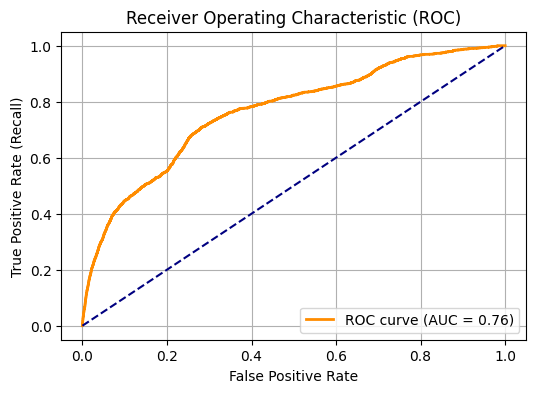

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, ensemble_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

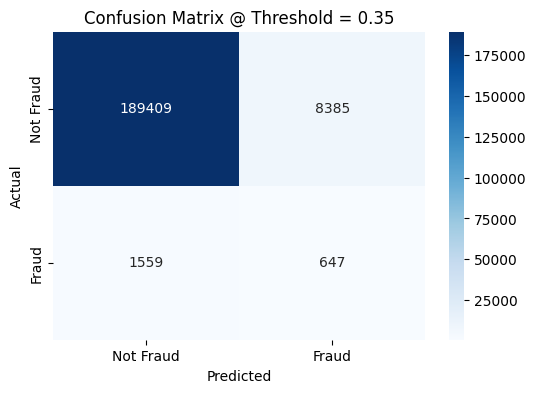

In [32]:
y_pred = (ensemble_score > 0.35).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix @ Threshold = 0.35')
plt.show()